# Coursework 2: Fish Classification

Created by Athanasios Vlontzos and Wenjia Bai

In this coursework, you will be exploring the application of convolutional neural networks for image classification tasks. As opposed to standard applications such as object or face classification, we will be dealing with a slightly different domain, fish classification for precision fishing.

In precision fishing, engineers and fishmen collaborate to extract a wide variety of information about the fish, their species and wellbeing etc. using data from satellite images to drones surveying the fisheries. The goal of precision fishing is to provide the marine industry with information to support their decision making processes.

Here your will develop an image classification model that can classify fish species given input images. It consists of **two tasks**. The **first task** is to **train a model for the following species**:
- Black Sea Sprat
- Gilt-Head Bream
- Shrimp
- Striped Red Mullet
- Trout

The **second task** is to **finetune the last layer of the trained model** to adapt to some new species, including:
- Hourse Mackerel
- Red Mullet
- Red Sea Bream
- Sea Bass

You will be working using a large-scale fish dataset [1].

[1] O. Ulucan, D. Karakaya and M. Turkan. A large-scale dataset for fish segmentation and classification. Innovations in Intelligent Systems and Applications Conference (ASYU). 2020.

## Step 0: Download data.

[Download the Data from here -- make sure you access it with your Imperial account.](https://imperiallondon-my.sharepoint.com/:f:/g/personal/av2514_ic_ac_uk/EkA9HyXVvgdFoLI4P_IfO1cBO_CsvY1KN4NE8iuD-s_VlA?e=Ip03rF)

It is a ~2.5GB file. You can save the images and annotations directories in the same directory as this notebook or somewhere else.

The fish dataset contains 9 species of fishes. There are 1,000 images for each fish species, named as %05d.png in each subdirectory.

## Step 1: Load the data. (15 Points)

- Complete the dataset class with the skeleton below.
- Add any transforms you feel are necessary.

Your class should have at least 3 elements
- An ```__init__``` function that sets up your class and all the necessary parameters.
- An ```__len__``` function that returns the size of your dataset.
- An ```__getitem__``` function that given an index within the limits of the size of the dataset returns the associated image and label in tensor form.

You may add more helper functions if you want.

In this section we are following the Pytorch [dataset](https://pytorch.org/vision/stable/datasets.html) class structure. You can take inspiration from their documentation.

In [1]:
# Dependencies
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import glob
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

C:\Users\85378\anaconda3\envs\ML\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\85378\anaconda3\envs\ML\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Some global constants, helper functions with indexes

In [2]:
# We will start by building a dataset class using the following 5 species
Multiclass_labels_correspondances = {
    'Black Sea Sprat': 0,
    'Gilt-Head Bream': 1,
    'Shrimp': 2,
    'Striped Red Mullet': 3,
    'Trout': 4
}

# The 5 species will contain 5,000 images in total.
# Helper function to get train, val, test indexs
# If require_val = True, will generate training (64%), valdation(16%) and test (20%) sets
def split_train_val_test(lendata, percentage=0.8, require_val = True):
    rg = np.random.default_rng()
    idxs = rg.permutation(lendata)
    idxs_train_val = idxs[:int(lendata*percentage)]
    idxs_test = idxs[int(lendata*percentage):]
    if require_val:
        idxs_train = idxs_train_val[:int(len(idxs_train_val)*percentage)]
        idxs_val = idxs_train_val[int(len(idxs_train_val)*percentage):]
    else:
        idxs_train = idxs_train_val
        idxs_val = None
    return idxs_train, idxs_val, idxs_test

# a helper function to shuffle train and val index
def shuffle_train_val_idx(idxs_train, idxs_val):
    new_idxs_all = np.concatenate([idxs_train, idxs_val])
    np.random.shuffle(new_idxs_all)
    idxs_train_new = new_idxs_all[:len(idxs_train)]
    idxs_val_new = new_idxs_all[len(idxs_train):]
    return idxs_train_new, idxs_val_new

LENDATA = 5000
np.random.seed(42)
idxs_train, idxs_val, idxs_test = split_train_val_test(LENDATA,0.8)

Dataset class Implementation

In [3]:
class FishDataset(Dataset):
    def __init__(self,
                 path_to_images,
                 idxs_train,
                 idxs_val,
                 idxs_test,
                 transform_extra=None, 
                 img_size=128,
                 mode = "train"):
        """
        path_to_images: where you put the fish dataset
        idxs_train: training set indexes
        idxs_val: validation set indexes, can be None
        idxs_test: test set indexes
        transform_extra: extra PIL transformation method
        img_size: resize all images to a standard size
        mode: "train", "val" or "test"
        """
        assert (mode in ["train", "val", "test"])
        self.idxs_train = idxs_train
        self.idxs_val = idxs_val
        self.idxs_test = idxs_test
        self.transform_extra = transform_extra
        self.img_size = img_size
        self.mode = mode
        self.images = []
        self.labels = []
        
        # Load all the images and their labels
        each_img_path_all = glob.glob(path_to_images + "/*/*")
        # only store wanted class, resize, extract the images and labels
        for path in each_img_path_all:
            for wanted_class in Multiclass_labels_correspondances.keys():
                if wanted_class in path:
                    original_im=Image.open(path)
                    if transform_extra:
                        im = original_im.transform((img_size,img_size), transform_extra)
                    else:
                        im = original_im.resize((img_size,img_size))
                    self.images.append(im)
                    self.labels.append(Multiclass_labels_correspondances[wanted_class])
    
    def __len__(self):
        # Return the number of samples
        if self.mode == "train":
            return self.idxs_train.size
        elif self.mode == "val":
            return self.idxs_val.size
        else:
            return self.idxs_test.size
        
    def __getitem__(self, idx):
        # Get an image and its label using its index
        if self.mode == "train":
            idx_ = self.idxs_train[idx]
        elif self.mode == "val":
            idx_ = self.idxs_val[idx]
        else:
            idx_ = self.idxs_test[idx]
        single_img_tensor = transforms.ToTensor()(self.images[idx_])
        single_lab_tensor = torch.zeros(len(Multiclass_labels_correspondances), dtype = torch.float)
        single_lab_tensor[self.labels[idx_]] = 1
        return (single_img_tensor, single_lab_tensor)
    
    def set_mode(self, mode):
        # change datast mode
        assert (mode in ["train", "val", "test"])
        self.mode = mode
    
    def set_idx(self, idxs_train, idxs_val, idxs_test):
        # change index of train, val, and test dataset
        self.idxs_train = idxs_train
        self.idxs_val = idxs_val
        self.idxs_test = idxs_test

## Step 2: Explore the data. (15 Points)

### Step 2.1: Data visualisation. (5 points)

- Plot data distribution, i.e. the number of samples per class.
- Plot 1 sample from each of the five classes in the training set.

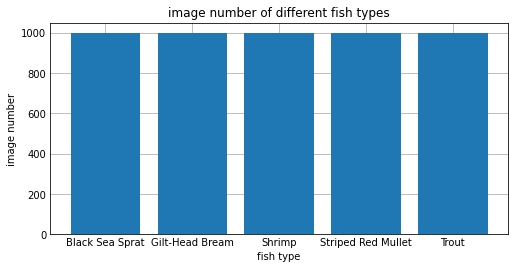

Black Sea Sprat


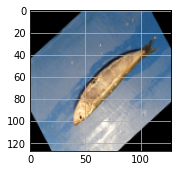

Gilt-Head Bream


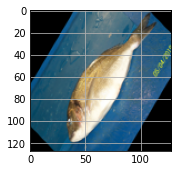

Shrimp


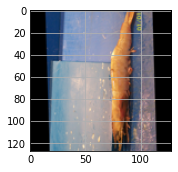

Striped Red Mullet


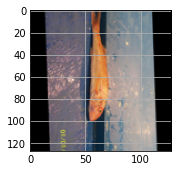

Trout


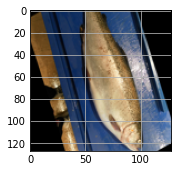

In [4]:
# Training set
img_path = "Fish_Dataset"
dataset  = FishDataset(img_path, idxs_train, idxs_val, idxs_test, mode = "train")

# Plot the number of samples per class
plt.style.use('_mpl-gallery')
fig = plt.gcf()
fig.set_size_inches(6.5, 3)
num2name = {value : key for (key, value) in Multiclass_labels_correspondances.items()}

labels_unique, labels_count = np.unique(np.array(dataset.labels), return_counts = True)
labels_unique = [num2name[i] for i in labels_unique]
plt.bar(labels_unique, labels_count)
plt.xlabel("fish type")
plt.ylabel("image number")
plt.title("image number of different fish types")
plt.show()

# Plot 1 sample from each of the five classes in the training set
for i in range(0, LENDATA, int(LENDATA/5)):
    img = dataset.images[i]
    label = dataset.labels[i]
    print(num2name[label])
    plt.imshow(img)
    plt.show()

### Step 2.2: Discussion. (10 points)

* Is the dataset balanced?

It is balanced because each class contains equal number (1000) of  image samples.

* Can you think of 3 ways to make the dataset balanced if it is not?

1. Downsample the majority: Select randomly equal number of images as the minority class.

2. Upsample the minority: Duplicate images (and potentially, add some noise or do some augmentation) in minority classes until each class has the same size.

3. Synthetic samples: Generate new images that are similar to original minority classes. For example, we can use KNN to detect similar images and synthesize a new image using K images' linear interpolation. 

* Is the dataset already pre-processed? If yes, how?

Yes, it has already been pre-processed. Taking Black Sea Sprat class as an exmaple, the original image has been rotated with different degrees(00001 vs. 00003), flipped(00001 vs. 00002). As far as I see, each original image is pre-processed using 10 rotations along with 2 flips, hence generating 20 augmentation images.

## Step 3: Multiclass classification. (55 points)
In this section we will try to make a multiclass classifier to determine the species of the fish.

### Step 3.1: Define the model. (15 points)

Design a neural network which consists of a number of convolutional layers and a few fully connected ones at the end.

The exact architecture is up to you but you do NOT need to create something complicated. For example, you could design a LeNet insprired network.

In [5]:
# a simple NiN block
def NiN_block(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential (
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), 
        nn.BatchNorm2d(out_channels), 
        nn.ReLU())

# a simple full_connection block
def full_connection(in_channels, out_channels):
    return nn.Sequential(
        nn.Linear(in_channels, in_channels),
        nn.BatchNorm1d(in_channels), 
        nn.ReLU(),
        nn.Dropout(0.4), 
        nn.Linear(in_channels, in_channels),
        nn.BatchNorm1d(in_channels), 
        nn.ReLU(),
        nn.Dropout(0.4), 
        nn.Linear(in_channels, out_channels))

class Net(nn.Module):
    def __init__(self, *args, output_dims = 1,):
        super(Net, self).__init__()
        for idx, block in enumerate(args):
            self._modules[str(idx)] = block
        
    def forward(self, x):
        # Forward propagation
        for block in self._modules.values():
            x = block(x)
        return x
    
    def __iter__(self):
        return iter(self._modules.values())

### Step 3.2: Define the training parameters. (10 points)

- Loss function
- Optimizer
- Learning Rate
- Number of iterations
- Batch Size
- Other relevant hyperparameters

In [6]:
model = Net(
    NiN_block(3, 96, kernel_size=11, strides = 2, padding=0),
    nn.MaxPool2d(3, stride=2),
    NiN_block(96, 256, kernel_size=5, strides = 2, padding=0), 
    nn.MaxPool2d(3, stride=2), 
    NiN_block(256, 384, kernel_size=3, strides = 1, padding=1), 
    nn.MaxPool2d(3, stride=2), 
    nn.Flatten(),
    full_connection(1536, 5))

# Loss function, softmax will be done automatically here
loss = nn.CrossEntropyLoss(reduction='none')
# Optimiser and learning rate
lr = 0.05
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Number of iterations for training
epochs = 20
# Training batch size
train_batch_size = 128

In [7]:
print("---------------------Layer shape check---------------------")
X = torch.rand(size=(4, 3, 128, 128))
model.to(device)
X = X.to(device)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

---------------------Layer shape check---------------------
Sequential output shape:	 torch.Size([4, 96, 59, 59])
MaxPool2d output shape:	 torch.Size([4, 96, 29, 29])
Sequential output shape:	 torch.Size([4, 256, 13, 13])
MaxPool2d output shape:	 torch.Size([4, 256, 6, 6])
Sequential output shape:	 torch.Size([4, 384, 6, 6])
MaxPool2d output shape:	 torch.Size([4, 384, 2, 2])
Flatten output shape:	 torch.Size([4, 1536])
Sequential output shape:	 torch.Size([4, 5])


In [8]:
# Based on the FishDataset, use the PyTorch DataLoader to load the data during model training
train_dataset = FishDataset(img_path, idxs_train, idxs_val, idxs_test, mode = "train")
val_dataset = FishDataset(img_path, idxs_train, idxs_val, idxs_test, mode = "val")
test_dataset = FishDataset(img_path, idxs_train, idxs_val, idxs_test, mode = "test")
train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size)
val_dataloader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

### Step 3.3: Train the model. (15 points)

Below is the helper fucntion to train a model

In [9]:
def train_model(model, train_dataloader, loss, optimizer, epochs, lr, show_progress = False):
    model.to(device)
    
    if show_progress:
        it = tqdm(range(epochs))
    else:
        it = range(epochs)
        
    for epoch in it:
        model.train()
        loss_curve = []
        # Get a batch of training data and train the model
        for i, (x, y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            y_hat = model(x)
            l = loss(y_hat, y).sum()
            l.backward()
            optimizer.step()
            loss_curve.append(int(l))
        if show_progress:
            print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

Firstly, I will just train with arbitrary hyper parameters

In [10]:
train_model(model, train_dataloader, loss, optimizer, epochs, lr, show_progress = True)

  5%|▌         | 1/20 [00:06<02:12,  6.98s/it]

--- Iteration 1: training loss = 575.9600 ---


 10%|█         | 2/20 [00:13<02:01,  6.73s/it]

--- Iteration 2: training loss = 251.8000 ---


 15%|█▌        | 3/20 [00:20<01:52,  6.64s/it]

--- Iteration 3: training loss = 203.4000 ---


 20%|██        | 4/20 [00:26<01:45,  6.60s/it]

--- Iteration 4: training loss = 209.5600 ---


 25%|██▌       | 5/20 [00:33<01:38,  6.58s/it]

--- Iteration 5: training loss = 157.6400 ---


 30%|███       | 6/20 [00:39<01:32,  6.58s/it]

--- Iteration 6: training loss = 151.4800 ---


 35%|███▌      | 7/20 [00:46<01:25,  6.57s/it]

--- Iteration 7: training loss = 99.2400 ---


 40%|████      | 8/20 [00:52<01:18,  6.58s/it]

--- Iteration 8: training loss = 62.4000 ---


 45%|████▌     | 9/20 [00:59<01:12,  6.57s/it]

--- Iteration 9: training loss = 43.1200 ---


 50%|█████     | 10/20 [01:05<01:05,  6.57s/it]

--- Iteration 10: training loss = 28.9600 ---


 55%|█████▌    | 11/20 [01:12<00:59,  6.56s/it]

--- Iteration 11: training loss = 21.1200 ---


 60%|██████    | 12/20 [01:19<00:52,  6.56s/it]

--- Iteration 12: training loss = 16.1200 ---


 65%|██████▌   | 13/20 [01:25<00:46,  6.57s/it]

--- Iteration 13: training loss = 18.2000 ---


 70%|███████   | 14/20 [01:32<00:39,  6.58s/it]

--- Iteration 14: training loss = 9.4800 ---


 75%|███████▌  | 15/20 [01:38<00:32,  6.58s/it]

--- Iteration 15: training loss = 7.0000 ---


 80%|████████  | 16/20 [01:45<00:26,  6.58s/it]

--- Iteration 16: training loss = 11.1200 ---


 85%|████████▌ | 17/20 [01:52<00:19,  6.59s/it]

--- Iteration 17: training loss = 14.2400 ---


 90%|█████████ | 18/20 [01:58<00:13,  6.61s/it]

--- Iteration 18: training loss = 7.0800 ---


 95%|█████████▌| 19/20 [02:05<00:06,  6.61s/it]

--- Iteration 19: training loss = 7.0000 ---


100%|██████████| 20/20 [02:11<00:00,  6.60s/it]

--- Iteration 20: training loss = 4.2000 ---


### Step 3.4: Deploy the trained model onto the test set. (10 points)

In [11]:
# Deploy the model
model.to("cpu")
y_test = []
y_hat = []
model.eval()
for img_tensor, lab in test_dataloader:
    with torch.no_grad():
        y_test.append(int(lab.argmax()))
        y_hat_single = model(img_tensor.reshape(-1, 3, 128, 128)).reshape(-1)
        y_hat.append(int(y_hat_single.reshape(-1).argmax()))
y_test = np.array(y_test)
y_hat = np.array(y_hat)

### Step 3.5: Evaluate the performance of the model and visualize the confusion matrix. (5 points)

You can use sklearns related function.

I will just implement it. Note that the following confusion_matrix and accuracy functions are retrieved from Introduction to Machine Learning lab notes. Students who take that course may use the same code. 

In [12]:
def confusion_matrix(y_gold, y_prediction, class_labels = None):
    """
    compute confusion matrix given ground truth label and prediction label
    """
    if not class_labels:
        class_labels = np.unique(np.concatenate((y_gold, y_prediction)))
    sorted(class_labels)
    confusion = np.zeros((len(class_labels), len(class_labels)), dtype=int)
    # for each correct class (row),
    # compute how many instances are predicted for each class (columns)
    for (i, label) in enumerate(class_labels):
        # get predictions where the ground truth is the current class label
        indices = (y_gold == label)
        gold = y_gold[indices]
        predictions = y_prediction[indices]
        # get the counts per label
        (unique_labels, counts) = np.unique(predictions, return_counts=True)
        # convert the counts to a dictionary
        frequency_dict = dict(zip(unique_labels, counts))
        # fill up the confusion matrix for the current row
        for (j, class_label) in enumerate(class_labels):
            confusion[i, j] = frequency_dict.get(class_label, 0)
    return confusion

def accuracy(y, y_prediction):
    """
    Compute the accuracy given the ground truth and predictions
    """
    assert len(y) == len(y_prediction)
    try:
        return np.sum(y == y_prediction) / len(y)
    except ZeroDivisionError:
        return 0.

In [13]:
confusion = confusion_matrix(y_test, y_hat)
print(confusion)
print("accuracy:", accuracy(y_test, y_hat))

[[188   0   0   0   0]
 [  4 214   0   3   0]
 [  0   0 177  13   0]
 [  7   0   3 198   0]
 [  6   2   1   0 184]]
accuracy: 0.961


Note that **above result is from arbitrary hyper parameters, it seems overfits a bit**. The following codes get the best hyper parameter using a brute search

In [14]:
def eval_acc(model ,dataloader_, require_confusion = False):
    model.to("cpu")
    y_test = []
    y_hat = []
    model.eval()
    for img_tensor, lab in dataloader_:
        with torch.no_grad():
            y_test.append(int(lab.argmax()))
            y_hat_single = model(img_tensor.reshape(-1, 3, 128, 128)).reshape(-1)
            y_hat.append(int(y_hat_single.reshape(-1).argmax()))
    y_test = np.array(y_test)
    y_hat = np.array(y_hat)
    if require_confusion:
        return accuracy(y_test, y_hat), confusion_matrix(y_test, y_hat)
    return accuracy(y_test, y_hat)


best_epoch_num = 0
best_bs = 0
best_lr = 0
best_val_acc = 0
best_state_dict = {}

for epochs in [10, 15, 20, 25]:
    for train_batch_size in [32, 64, 128]:
        for lr in [0.5, 0.2, 0.1, 0.05]:
            # initialize model weights
            for param in model.parameters():
                nn.init.uniform_(param)
            model.to(device)
            # shuffle train val idxs and assign to train and val datasetss
            idxs_train_, idxs_val_ = shuffle_train_val_idx(idxs_train, idxs_val)
            train_dataset.set_idx(idxs_train_, idxs_val_, idxs_test)
            val_dataset.set_idx(idxs_train_, idxs_val_, idxs_test)
            train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size)
            val_dataloader = DataLoader(val_dataset)
            loss = nn.CrossEntropyLoss(reduction='none')
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            train_model(model, train_dataloader, loss, optimizer, epochs, lr)
            
            # evaluate model performance on val_data and update best result 
            current_val_acc = eval_acc(model, val_dataloader)
            if current_val_acc > best_val_acc:
                best_epoch_num = epochs
                best_bs = train_batch_size
                best_lr = lr
                best_val_acc = current_val_acc
                best_state_dict = copy.deepcopy(model.state_dict())
                print(f"current best hyper params are epoch_num {best_epoch_num}, ", end = "")
                print(f"batch_size {best_bs}, learning rate {best_lr}, ", end = "")
                print(f"with best val acc {best_val_acc}")

current best hyper params are epoch_num 10, batch_size 32, learning rate 0.5, with best val acc 0.16375
current best hyper params are epoch_num 10, batch_size 32, learning rate 0.2, with best val acc 0.45
current best hyper params are epoch_num 10, batch_size 32, learning rate 0.1, with best val acc 0.81125
current best hyper params are epoch_num 10, batch_size 64, learning rate 0.1, with best val acc 0.9175
current best hyper params are epoch_num 15, batch_size 32, learning rate 0.1, with best val acc 0.96
current best hyper params are epoch_num 25, batch_size 32, learning rate 0.05, with best val acc 0.9825


In [15]:
model.load_state_dict(best_state_dict)
# Deploy the model and evaluate performance
acc, confusion = eval_acc(model, test_dataloader, require_confusion = True)
print(confusion)
print("accuracy:", acc)

[[188   0   0   0   0]
 [  3 213   0   2   3]
 [  0   0 190   0   0]
 [  2   0   0 206   0]
 [  0   0   0   0 193]]
accuracy: 0.99


## Step 4: Finetune your classifier. (15 points)

In the previous section, you have built a pretty good classifier for certain species of fish. Now we are going to use this trained classifier and adapt it to classify a new set of species:

    'Hourse Mackerel
    'Red Mullet',
    'Red Sea Bream'
    'Sea Bass'

### Step 4.1: Set up the data for new species. (2 points)
Overwrite the labels correspondances so they only incude the new classes and regenerate the datasets and dataloaders.

In [16]:
Multiclass_labels_correspondances ={
    'Hourse Mackerel': 0,
    'Red Mullet': 1,
    'Red Sea Bream': 2,
    'Sea Bass': 3}

LENDATA = 4000
idxs = split_train_val_test(LENDATA, 0.8, require_val = False)

# modify models as last layer only outputs 4 neurons
model._modules['7'] = full_connection(1536,4)

# Dataloaders
train_dataset = FishDataset(img_path, *idxs, mode = "train")
train_dataloader = DataLoader(train_dataset, batch_size = train_batch_size)
test_dataset = FishDataset(img_path, *idxs, mode = "test")
test_dataloader = DataLoader(test_dataset)

### Step 4.2: Freeze the weights of all previous layers of the network except the last layer. (5 points)

You can freeze them by setting the gradient requirements to ```False```.

In [17]:
def freeze_till_last(model):
    for name, param in model.named_parameters():
        param.requires_grad = False
    last_layer = model._modules[name.split('.')[0]]
    for param in last_layer.parameters():
        param.requires_grad = True

freeze_till_last(model)

In [18]:
print("---------------------Layer shape check---------------------")
X = torch.rand(size=(4, 3, 128, 128))
model.to(device)
X = X.to(device)
for layer in model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

---------------------Layer shape check---------------------
Sequential output shape:	 torch.Size([4, 96, 59, 59])
MaxPool2d output shape:	 torch.Size([4, 96, 29, 29])
Sequential output shape:	 torch.Size([4, 256, 13, 13])
MaxPool2d output shape:	 torch.Size([4, 256, 6, 6])
Sequential output shape:	 torch.Size([4, 384, 6, 6])
MaxPool2d output shape:	 torch.Size([4, 384, 2, 2])
Flatten output shape:	 torch.Size([4, 1536])
Sequential output shape:	 torch.Size([4, 4])


In [19]:
# Loss function, softmax will be done aptumatically here
loss = nn.CrossEntropyLoss(reduction='none') 

# Optimiser and learning rate
lr = best_lr
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# Number of iterations for training
epochs = best_epoch_num
# Training batch size
train_batch_size = best_bs

### Step 4.3: Train and test your finetuned model. (5 points)

In [20]:
# Finetune the model
model.to(device)
for epoch in tqdm(range(epochs)):
    model.train()
    loss_curve = []
    # Get a batch of training data and train the model
    for i, (x,y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        l = loss(y_hat, y).sum()
        l.backward()
        optimizer.step()
        loss_curve.append(int(l))
    print('--- Iteration {0}: training loss = {1:.4f} ---'.format(epoch + 1, np.array(loss_curve).mean()))

  4%|▍         | 1/25 [00:05<02:04,  5.20s/it]

--- Iteration 1: training loss = 370.5200 ---


  8%|▊         | 2/25 [00:10<01:55,  5.04s/it]

--- Iteration 2: training loss = 81.3200 ---


 12%|█▏        | 3/25 [00:15<01:54,  5.21s/it]

--- Iteration 3: training loss = 66.3600 ---


 16%|█▌        | 4/25 [00:21<01:53,  5.41s/it]

--- Iteration 4: training loss = 55.3600 ---


 20%|██        | 5/25 [00:26<01:49,  5.46s/it]

--- Iteration 5: training loss = 49.1200 ---


 24%|██▍       | 6/25 [00:31<01:40,  5.28s/it]

--- Iteration 6: training loss = 44.3600 ---


 28%|██▊       | 7/25 [00:37<01:35,  5.32s/it]

--- Iteration 7: training loss = 37.7600 ---


 32%|███▏      | 8/25 [00:42<01:29,  5.24s/it]

--- Iteration 8: training loss = 35.7600 ---


 36%|███▌      | 9/25 [00:47<01:22,  5.13s/it]

--- Iteration 9: training loss = 31.7200 ---


 40%|████      | 10/25 [00:51<01:15,  5.05s/it]

--- Iteration 10: training loss = 31.4400 ---


 44%|████▍     | 11/25 [00:56<01:10,  5.02s/it]

--- Iteration 11: training loss = 30.4400 ---


 48%|████▊     | 12/25 [01:01<01:03,  4.88s/it]

--- Iteration 12: training loss = 29.2000 ---


 52%|█████▏    | 13/25 [01:07<01:00,  5.08s/it]

--- Iteration 13: training loss = 24.2800 ---


 56%|█████▌    | 14/25 [01:12<00:57,  5.22s/it]

--- Iteration 14: training loss = 23.3600 ---


 60%|██████    | 15/25 [01:17<00:52,  5.22s/it]

--- Iteration 15: training loss = 20.7600 ---


 64%|██████▍   | 16/25 [01:23<00:48,  5.39s/it]

--- Iteration 16: training loss = 21.7200 ---


 68%|██████▊   | 17/25 [01:28<00:43,  5.38s/it]

--- Iteration 17: training loss = 21.3200 ---


 72%|███████▏  | 18/25 [01:34<00:37,  5.35s/it]

--- Iteration 18: training loss = 20.4000 ---


 76%|███████▌  | 19/25 [01:39<00:31,  5.31s/it]

--- Iteration 19: training loss = 20.9600 ---


 80%|████████  | 20/25 [01:44<00:26,  5.24s/it]

--- Iteration 20: training loss = 19.0400 ---


 84%|████████▍ | 21/25 [01:49<00:20,  5.20s/it]

--- Iteration 21: training loss = 18.4800 ---


 88%|████████▊ | 22/25 [01:55<00:16,  5.50s/it]

--- Iteration 22: training loss = 20.3600 ---


 92%|█████████▏| 23/25 [02:01<00:11,  5.64s/it]

--- Iteration 23: training loss = 16.6000 ---


 96%|█████████▌| 24/25 [02:07<00:05,  5.61s/it]

--- Iteration 24: training loss = 16.9600 ---


100%|██████████| 25/25 [02:13<00:00,  5.32s/it]

--- Iteration 25: training loss = 17.0800 ---


In [21]:
# Deploy the model and evaluate performance
acc, confusion = eval_acc(model, test_dataloader, require_confusion = True)
print(confusion)
print("accuracy:", acc)

[[146  21   7  14]
 [  0 211   0   0]
 [  2   0 182   0]
 [ 28   8   5 176]]
accuracy: 0.89375


### Step 4.4: Did finetuning work? Why did we freeze the first few layers? (3 points)

Yes, finetuning works well.

Reason for freezing the first few layers:

When finetuning, we are using a pretained model on a similar fish classiication task. The feature extractor (namely, first few convolutional layers) in the pretrained model may generalize well to other tasks and does not need to be retrained. This saves a lot of time and computation, reaching a good result in just a few epochs. 

For example, compared with the original model, the loss of first 5 epochs in fintuning is dramatically smaller, and time spent to train each epoch also decreases from around 6.6 seconds to 5.3 seconds. 

Note that I just use the best hyperparameter from the previous task to save training time, they are not the best ones for this task. But it still reaches a quite good accuracy (89.7%). I believe after hyper parameter tuning, model performance on this task will improve dramatically